<a href="https://colab.research.google.com/github/svgl0829/test1/blob/master/TensorFlow_bubble_0207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from math import sqrt

In [ ]:
def gray_image_creater(IMG_SIZE, RAD, num_bub):
  img = np.full((IMG_SIZE,IMG_SIZE, 3), 192, np.uint8)
  
  location_x = []
  location_y = []
  
  for i in range(num_bub):
    
    while True:
      x = int(random.uniform(RAD, IMG_SIZE - RAD))
      y = int(random.uniform(RAD, IMG_SIZE - RAD))
      
      if i == 0:
        break
        
      #気泡どおしの距離
      d = [sqrt((location_x[j] - x) ** 2 + (location_y[j] - y) ** 2) for j in range(i)]
      
      NG_counter = 0
      for j in range(i):
        if d[j] < 2* RAD:
          #重なり具合を指定
          NG_counter = NG_counter + 1
      
      if NG_counter == 0:
        break
        
    cv2.circle(img, (x, y), RAD, (0, 0, 0), -1)
    location_x.append(x)
    location_y.append(y)

    img_gray = img[:, :, 1] #3channel -> 1channel
  
  return img_gray

20000 / 120000


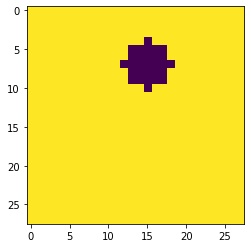

40000 / 120000


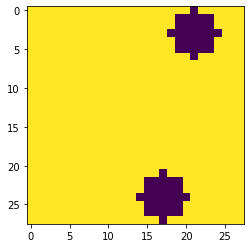

60000 / 120000


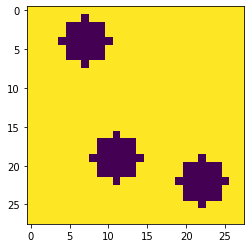

80000 / 120000


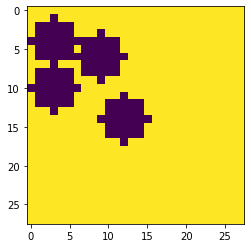

100000 / 120000


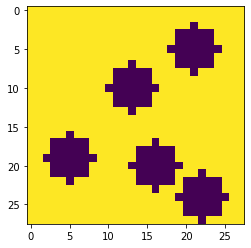

120000 / 120000


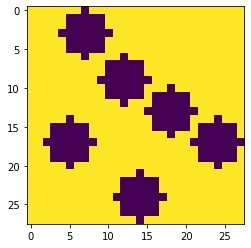

In [ ]:
#大量のgray画像を作成

#画像のサイズ
IMG_SIZE = 28
#気泡半径
RAD = 3
#気泡数
NUM_BUB = 6
#作成する図の数
NUM_IMG = 20000

data = []
teacher_labels = []

counter = 0
#気泡の数のループ
for num_bub in range(NUM_BUB):

  #作成する図の数のループ
  for num_img in range(NUM_IMG):
    
    #gray図の作成
    img = gray_image_creater(IMG_SIZE, RAD, num_bub+1)

    data.append(img)
    teacher_labels.append(num_bub)
    
    #進行状況
    counter = counter + 1
    if counter%20000 == 0:
      print(str(counter) + ' / ' +str(NUM_IMG * NUM_BUB)) 
      plt.imshow(img)
      plt.show()


In [ ]:
BATCH_SIZE = 20
NUM_CLASSES = NUM_BUB
EPOCHS = 16

IMG_ROWS, IMG_COLS = IMG_SIZE, IMG_SIZE

bubble_number_names = ['1', '2', '3', '4', '5', '6']

In [ ]:
#学習用と訓練用に分ける
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
train_teacher_labels, test_teacher_labels = train_test_split(teacher_labels, test_size=0.2, random_state=0)

#nparrayに変換
train_data = np.array(train_data)
train_teacher_labels = np.array(train_teacher_labels)
test_data = np.array(test_data)
test_teacher_labels = np.array(test_teacher_labels)

teacher label is 1


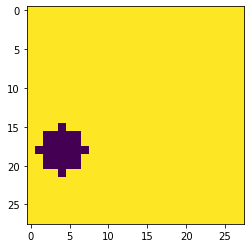

In [ ]:
#画像の表示
data_location = 100
print('teacher label is ' + str(train_teacher_labels[data_location] + 1)) #teacher_labelは0から始まるので、調整の１が必要
plt.imshow(train_data[data_location])
plt.show()

In [ ]:
from keras import backend as Keras

print('Channel調整変換前　train_data shape:', train_data.shape)
print('Channel調整変換前　test_data shape:', test_data.shape)

if Keras.image_data_format() == 'channels=first':
  train_data = train_data.reshape(train_data.shape[0], 1, IMG_ROWS, IMG_COLS)
  test_data = test_data.reshape(test_data[0], 1, IMG_ROWS, IMG_COLS)
  input_shape = (1, IMG_ROWS, IMG_COLS)

else:
  train_data = train_data.reshape(train_data.shape[0], IMG_ROWS, IMG_COLS, 1)
  test_data = test_data.reshape(test_data.shape[0], IMG_ROWS, IMG_COLS, 1)
  input_shape = (IMG_ROWS, IMG_COLS, 1)

print('Channel調整変換後　train_data shape:', train_data.shape)
print('Channel調整変換後　test_data shape:', test_data.shape)

Channel調整変換前　train_data shape: (96000, 28, 28)
Channel調整変換前　test_data shape: (24000, 28, 28)
Channel調整変換後　train_data shape: (96000, 28, 28, 1)
Channel調整変換後　test_data shape: (24000, 28, 28, 1)


In [ ]:
#float32に変換
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

In [ ]:
#0から１の間に分布させる
train_data /= 255
test_data /= 255

In [ ]:
#学習用教師用ラベルデータをOne-hotベクトルに変換
print('Keras変換前学習用教師用ラベルデータ train_teacher_labels shape:', train_teacher_labels.shape)
train_teacher_labels = keras.utils.to_categorical(train_teacher_labels, NUM_CLASSES)
print('Keras変換後学習用教師用ラベルデータ train_teacher_labels shape:', train_teacher_labels.shape)

#検証用教師用ラベルデータをOne-hotベクトルに変換
print('Keras変換前検証用教師用ラベルデータ test_teacher_labels shape:', test_teacher_labels.shape)
test_teacher_labels = keras.utils.to_categorical(test_teacher_labels, NUM_CLASSES)
print('Keras変換後検証用教師用ラベルデータ test_teacher_labels shape:', test_teacher_labels.shape)

Keras変換前学習用教師用ラベルデータ train_teacher_labels shape: (96000,)
Keras変換後学習用教師用ラベルデータ train_teacher_labels shape: (96000, 6)
Keras変換前検証用教師用ラベルデータ test_teacher_labels shape: (24000,)
Keras変換後検証用教師用ラベルデータ test_teacher_labels shape: (24000, 6)


In [ ]:
#ニューラルネットワークのモデル構築
#Sequential Modelを採用
from keras.models import Sequential

model = Sequential()

In [ ]:
#モデル構築のためのClassのインポート
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
#ニューラルネットワークの構築
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) #畳み込みレイヤーの追加
#Conv2D:　二次元の畳み込みレイヤー,　32:入力するニューロンの数, kernel_size: 畳み込みエリアの幅と高さ, activation:　活性化関数, input_shape: 入力データの形状
model.add(Conv2D(64, (3, 3), activation='relu')) #２つめの畳み込みレイヤーの追加
model.add(MaxPooling2D(pool_size=(2, 2))) #プーリング層（圧縮）
model.add(Dropout(0.25)) #ドロップアウト層：　過学習を防ぐ
model.add(Flatten()) #入力を平滑化する: １次元にする
model.add(Dense(128, activation='relu')) #全結合レイヤー
model.add(Dropout(0.5)) #ドロップアウト層：　過学習を防ぐ
model.add(Dense(NUM_CLASSES, activation='softmax')) #出力層　出力の各クラスの確率の形に変換する

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
#モデルをどのように学習処理するか設定
#最適化アルゴリズム(optimizer)、損失関数(loss)、評価関数のリスト(metrics、分類問題では正答率を使う)

model.compile(optimizer=keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
print('学習させる前: train_data shape:', train_data.shape)
print('学習させる前: test_data shape:', test_data.shape)

学習させる前: train_data shape: (96000, 28, 28, 1)
学習させる前: test_data shape: (24000, 28, 28, 1)


In [ ]:
#学習のグラフを描写する関数を定義

def plot_loss_accyracy_graph(fit_record):
  #青い線で誤差の履歴をプロット、黒い線で検証時の誤差をプロット
  plt.plot(fit_record.history['loss'], "-D", color='blue', label='train_loss', linewidth=2)
  plt.plot(fit_record.history['val_loss'], "-D", color='black', label='val_loss', linewidth=2)
  plt.title('LOSS')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.show()

  #緑の線で精度の履歴をプロット、黒い線で検証時の精度をプロット
  plt.plot(fit_record.history['accuracy'], "-o", color='green', label='train_accuracy', linewidth=2)
  plt.plot(fit_record.history['val_accuracy'], "-o", color='black', label='val_accuracy', linewidth=2)
  plt.title('ACCURACY')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
#学習

print('反復学習回数：', EPOCHS)
fit_record = model.fit(train_data, train_teacher_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(test_data, test_teacher_labels))

反復学習回数： 16
Epoch 1/16
4800/4800 [==============================] - 250s 52ms/step - loss: 1.7889 - accuracy: 0.1923 - val_loss: 1.7005 - val_accuracy: 0.3444
Epoch 2/16
4800/4800 [==============================] - 255s 53ms/step - loss: 1.6849 - accuracy: 0.3136 - val_loss: 1.5453 - val_accuracy: 0.3750
Epoch 3/16
4800/4800 [==============================] - 256s 53ms/step - loss: 1.5375 - accuracy: 0.3893 - val_loss: 1.3878 - val_accuracy: 0.4167
Epoch 4/16
4800/4800 [==============================] - 258s 54ms/step - loss: 1.4005 - accuracy: 0.4295 - val_loss: 1.2418 - val_accuracy: 0.5404
Epoch 5/16
4800/4800 [==============================] - 259s 54ms/step - loss: 1.2799 - accuracy: 0.4677 - val_loss: 1.1147 - val_accuracy: 0.6506
Epoch 6/16
4800/4800 [==============================] - 262s 55ms/step - loss: 1.1741 - accuracy: 0.5095 - val_loss: 1.0083 - val_accuracy: 0.7135
Epoch 7/16
4800/4800 [==============================] - 260s 54ms/step - loss: 1.0928 - accuracy: 0.5370 - 

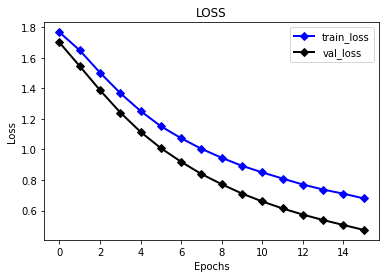

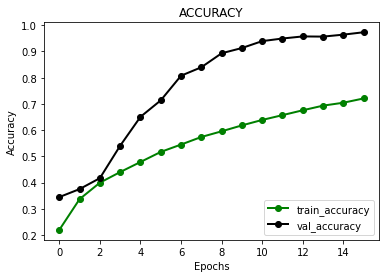

In [ ]:
plot_loss_accyracy_graph(fit_record)

In [ ]:
#検証
result_score = model.evaluate(test_data, test_teacher_labels, verbose=0)

In [ ]:
print('検証誤差: ', result_score[0])
print('検証正解率: ', result_score[1])

検証誤差:  0.47324129939079285
検証正解率:  0.9734583497047424


In [ ]:
#予測
prediction_array = model.predict(test_data)

In [ ]:
#画像の描写する関数
#prediction_arrayの中身を見ることが目的
def plot_image(data_location, predictions_array, real_teacher_labels, dataset):
  prediction_array, real_teacher_labels, img = predictions_array[data_location], real_teacher_labels[data_location], dataset[data_location]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)

  predicted_label = np.argmax(prediction_array)
  #文字の色：予測結果と実際のラベルと一致する場合は緑、一致しない場合は赤
  if predicted_label == real_teacher_labels:
    color = 'green'
  else:
    color = 'red'

  #np.maxはnumpyの関数で、指定した配列の中の最大値を取り出す
  #ここでpredictions_arrayの最大値を返す
  plt.xlabel('{} {:2.0f}% ({})'. format(bubble_number_names[predicted_label], 100 * np.max(predictions_array), bubble_number_names[real_teacher_labels]), color=color)


In [ ]:
#予測した結果をヒストグラムで描写する関数
def plot_teacher_labels_graph(data_location, predictions_array, real_teacher_labels):
  predictions_array, real_teacher_labels = predictions_array[data_location], real_teacher_labels[data_location]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  thisplot = plt.bar(range(NUM_BUB), predictions_array, color='#666666')
  plt.ylim([0,1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[real_teacher_labels].set_color('green')

In [ ]:
#One-hotベクトルを整数の配列に変換する関数
import numpy as np

def convertOneHotVercor2Integers(one_hot_vector):
  return [np.where(r == 1)[0][0] for r in one_hot_vector]

In [ ]:
#描写のために検証データを変換しておく
test_data = test_data.reshape(test_data.shape[0], IMG_ROWS, IMG_COLS)

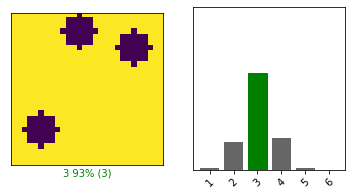

In [ ]:
#検証結果の確認
data_location = 77
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plot_image(data_location, prediction_array, convertOneHotVercor2Integers(test_teacher_labels), test_data)

plt.subplot(1,2,2)
plot_teacher_labels_graph(data_location, prediction_array, convertOneHotVercor2Integers(test_teacher_labels))
_ = plt.xticks(range(NUM_BUB), bubble_number_names, rotation=45)

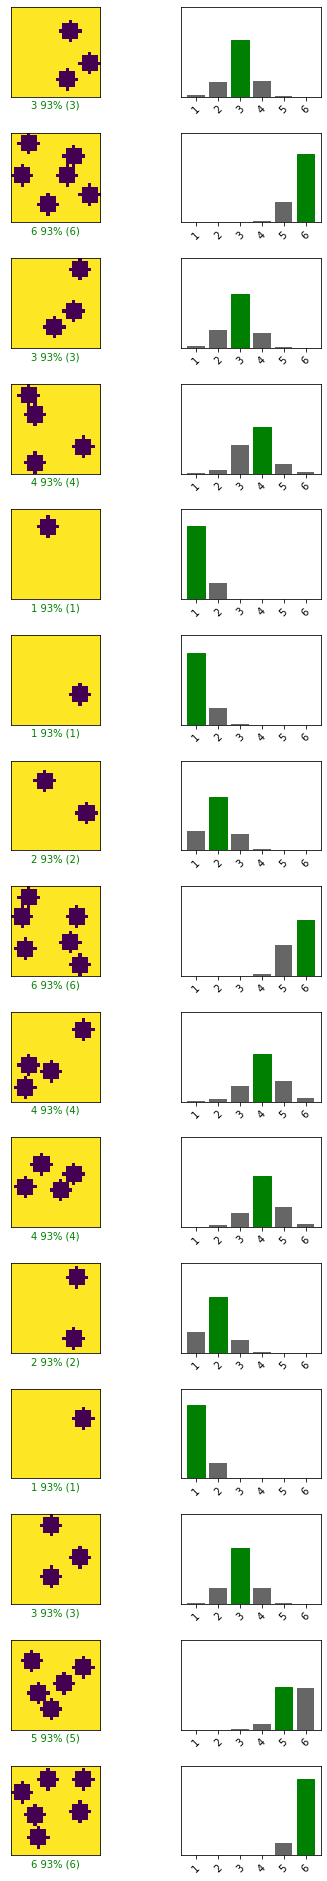

In [ ]:
NUM_ROWS = 15
NUM_COLS = 1
NUM_IMAGES = NUM_ROWS * NUM_COLS

plt.figure(figsize=(2 * 2 * NUM_COLS + 2, 2* NUM_ROWS + 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(NUM_IMAGES):
  plt.subplot(NUM_ROWS, 2 * NUM_COLS, 2 * i + 1)
  plot_image(i, prediction_array, convertOneHotVercor2Integers(test_teacher_labels), test_data)

  plt.subplot(NUM_ROWS, 2 * NUM_COLS, 2 * i + 2)
  plot_teacher_labels_graph(i, prediction_array, convertOneHotVercor2Integers(test_teacher_labels))
  _ = plt.xticks(range(NUM_BUB), bubble_number_names, rotation=45)

In [ ]:
#学習データを作成
train_data = []
train_teacher_labels = []

for i in range(0, len(train_file_name)):
  
  #学習データ
  img_bgr = cv2.imread(path_train + '/' + train_file_name[i])
  img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
  train_data.append(img_gray)

  #教師ラベル
  label = train_file_name[i][0:1]
  train_teacher_labels.append(np.int32(label) - 1) #予測値は１小さくする（0から始めるために）

#検証データを作成
test_data = []
test_teacher_labels = []

for i in range(0, len(test_file_name)):
  #検証データ
  img_bgr = cv2.imread(path_test + '/' + test_file_name[i])
  img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
  test_data.append(img_gray)

  #教師ラベル
  label = test_file_name[i][0:1] 
  test_teacher_labels.append(np.int32(label) - 1) #予測値は１小さくする（0から始めるために）

train_data = np.array(train_data)
train_teacher_labels = np.array(train_teacher_labels)
test_data = np.array(test_data)
test_teacher_labels = np.array(test_teacher_labels)

In [ ]:
#データを作成

path = '/content/drive/MyDrive/Colaboratory/bubble_counter/img0203_1'

file_name = os.listdir(path)
len(file_name)

data = []
teacher_labels = []

for i in range(0, len(file_name)):
  
  #データ
  img_bgr = cv2.imread(path + '/' + file_name[i])
  img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
  data.append(img_gray)

  #教師ラベル
  label = file_name[i][0:1]
  teacher_labels.append(np.int32(label) - 1) #予測値は１小さくする（0から始めるために）

  print(str(i) + ' / ' +str(len(file_name)))